In [ ]:
pip install unidecode

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import unidecode

In [ ]:
df_cust = pd.read_csv('Dataset/olist_customers_dataset.csv')                        # Customers
df_geo = pd.read_csv('Dataset/olist_geolocation_dataset.csv')                       # Geolocation
df_order_items = pd.read_csv('Dataset/olist_order_items_dataset.csv')               # Order Items
df_order_payments = pd.read_csv('Dataset/olist_order_payments_dataset.csv')         # Order Payments
df_order_reviews = pd.read_csv('Dataset/olist_order_reviews_dataset.csv')           # Order Reviews
df_order = pd.read_csv('Dataset/olist_orders_dataset.csv')                          # Order
df_products = pd.read_csv('Dataset/olist_products_dataset.csv')                     # Products
df_sellers = pd.read_csv('Dataset/olist_sellers_dataset.csv')                       # Sellers
df_product_category = pd.read_csv('Dataset/product_category_name_translation.csv')  # Product Category

# **A. Dataset Merging & Anomaly Founds**

## **1. Products Dataset Merging**

Tables used:
1. Products
2. Products Category

Output DataFrame Variable: `products`

In [ ]:
# Null Check

print(f'Products:\n{df_products.isna().sum()}')
print(f'\nProducts Category:\n{df_product_category.isna().sum()}')

In [ ]:
# Random Check On Products Dataset

# filtered_df = df_products[pd.isna(df_products['product_category_name'])]
filtered_df = df_products[pd.isna(df_products['product_weight_g'])]
filtered_df

# Drop Null Values
df_products.dropna(subset = ['product_category_name'], inplace = True)

# Fill Null Values with 0
df_products.fillna(0, inplace = True)

display(df_products.head())
display(df_products.info())

In [ ]:
products = pd.merge(df_products, df_product_category,
                    how = 'left', on = 'product_category_name')

# Check for products which don;t have translator yet
products[pd.isna(products['product_category_name_english'])][['product_category_name', 'product_category_name_english']]

In [ ]:
# There are two product categories in portuguese which don't have the translate yet:
# portateis_cozinha_e_preparadores_de_alimentos	- portable_kitchen_and_food_preparation_tools
# pc_gamer - gamer_pc

add_categories = pd.DataFrame({
    'product_category_name' : ['portateis_cozinha_e_preparadores_de_alimentos', 'pc_gamer'],
    'product_category_name_english' : ['portable_kitchen_and_food_preparation_tools', 'gamer_pc']
})

df_product_category = pd.concat([df_product_category, add_categories],
                                ignore_index = True)

df_product_category

In [ ]:
# Re - Merge
products = pd.merge(df_products, df_product_category,
                    how = 'left', on = 'product_category_name')

In [ ]:
products.info()

In [ ]:
# Drop Product Category Name in Portuguese
products.drop(columns = 'product_category_name', inplace = True)

# Renaming Product Category Name in English
products.rename(columns = {'product_category_name_english' : 'product_cat_name'}, inplace = True)

# Reordering Columns
new_col_order = ['product_id', 'product_cat_name', 'product_name_lenght', 
                  'product_description_lenght', 'product_photos_qty', 'product_weight_g', 
                  'product_length_cm', 'product_height_cm', 'product_width_cm']

products = products[new_col_order]
products.head()

## **2. Geolocation Dataset Merging**

Tables used:
1. Geolocation

Output DataFrame Variable : `geolocation`

In [ ]:
# Normalizing Cities Name Formats
df_geo.geolocation_city = df_geo.geolocation_city.apply(lambda x: unidecode.unidecode(x))

In [ ]:
df_geo

In [ ]:
df_geo_zip_codes = df_geo['geolocation_zip_code_prefix'].unique()

df_zip_code_desc = pd.DataFrame(columns = ['Zip Code', 'Min Lat', 'Max Lat', 'Lat Diff', 'Median Lat',
                                           'Min Lng', 'Max Lng', 'Lng Diff', 'Median Lng',
                                           'Count', 'State', 'City'])

geo_list = []

def compute_geo_stats(df):
    min_lat = df['geolocation_lat'].min()
    max_lat = df['geolocation_lat'].max()
    median_lat = df['geolocation_lat'].median()
    min_lng = df['geolocation_lng'].min()
    max_lng = df['geolocation_lng'].max()
    median_lng = df['geolocation_lng'].median()
    
    return min_lat, max_lat, median_lat, min_lng, max_lng, median_lng

for zip_code in df_geo_zip_codes:
    df_temp = df_geo[df_geo['geolocation_zip_code_prefix'] == zip_code]
    states = df_temp.geolocation_state.unique()
    
    for state in states:
        df_temp_states = df_temp[df_temp['geolocation_state'] == state]
        cities = df_temp_states.geolocation_city.unique()
        
        for city in cities:
            df_temp_states_city = df_temp_states[df_temp_states['geolocation_city'] == city]
            min_lat, max_lat, median_lat, min_lng, max_lng, median_lng = compute_geo_stats(df_temp_states_city)
            geo_list.append({
                'Zip Code': zip_code,
                'Min Lat': min_lat,
                'Max Lat': max_lat,
                'Lat Diff': max_lat - min_lat,
                'Median Lat': median_lat,
                'Min Lng': min_lng,
                'Max Lng': max_lng,
                'Lng Diff': max_lng - min_lng,
                'Median Lng': median_lng,
                'Count': len(df_temp_states_city),
                'State': df_temp_states_city.geolocation_state.unique()[0],
                'City': df_temp_states_city.geolocation_city.unique()[0]
            })
    
df_zip_code_desc = pd.concat([df_zip_code_desc, pd.DataFrame(geo_list)], 
                             ignore_index = True)

display(df_zip_code_desc)

In [ ]:
# df_zip_code_desc.City.unique()

In [ ]:
print(df_zip_code_desc['Lat Diff'].min())
print(df_zip_code_desc['Lat Diff'].max())
print(df_zip_code_desc['Lng Diff'].min())
print(df_zip_code_desc['Lng Diff'].max())

In [ ]:
geolocation = df_zip_code_desc[['Zip Code', 'State', 'Median Lat', 'Median Lng', 'City']]
geolocation.rename(columns = {'Median Lat' : 'Latitude',
                              'Median Lng': 'Longitude'},
                   inplace = True)
geolocation

## **3. Order Dataset Merging**

Tables used:
1. Products (Already Cleaned)
1. Order
2. Order Items
3. Order Payments
4. Order Reviews

Output DataFrame Variable : `order_grouped`

### **3.1. Orders Data Checking & Cleaning**

In [ ]:
display(df_order.info())
display(df_order_items.info())
display(df_order_payments.info())
display(df_order_reviews.info())

#### **3.1.1. Check `df_order` dataset on NaN values**

In [ ]:
display(df_order.info())

In [ ]:
data_summary = []

def add_summary(order_date_column, order_status_column, label):
    nan_status = df_order[pd.isna(df_order[order_date_column])]
    non_nan_status = df_order[pd.notna(df_order[order_date_column])]
    
    data_summary.append({
        'Label': label,
        'Unique Order Status (NaN)': nan_status[order_status_column].unique(),
        'Count Unique Order Status (NaN)': len(nan_status),
        'Unique Order Status (Non-NaN)': non_nan_status[order_status_column].unique(),
        'Count Unique Order Status (Non-NaN)': len(non_nan_status)
    })

add_summary('order_approved_at', 'order_status', 'Approved Date')
add_summary('order_delivered_carrier_date', 'order_status', 'Delivered Carrier Date')
add_summary('order_delivered_customer_date', 'order_status', 'Delivered Customer Date')

df_summary = pd.DataFrame(data_summary)

display(df_summary)

In [ ]:
# Dropna

df_order.dropna(inplace = True)
df_order.info()

#### **3.1.2. Drop `df_order_reviews` columns with NaN values**

In [ ]:
df_order_reviews.drop(columns = ['review_comment_title', 'review_comment_message'],
                      inplace = True)
display(df_order_reviews.info())

### **3.2. Check `order_id`**

> Check the suitability of `order_id` feature between datasets before merging

In [ ]:
# Check Unique Order ID Count on each dataser

print(f'Order Unique order_id count : {len(df_order.order_id.unique())}')
print(f'Order Items Unique order_id count : {len(df_order_items.order_id.unique())}')
print(f'Order Payments Unique order_id count : {len(df_order_payments.order_id.unique())}')
print(f'Order Reviews Unique order_id count : {len(df_order_reviews.order_id.unique())}')

In [ ]:
# Checking Order IDs pairs in excel
order_ids = [df_order['order_id'].unique(), 
             df_order_items['order_id'].unique(), 
             df_order_reviews['order_id'].unique(),
             df_order_payments['order_id'].unique()]

df_order_ids = pd.DataFrame(order_ids).T
df_order_ids.columns = ['order', 'order_items', 'order_reviews', 'order_payments']

display(df_order_ids)

# To Excel
df_order_ids.to_excel('order_ids.xlsx')

Checking Result:

1. There is one `order_id` that doesn't have any payment records, which is `bfbd0f9bdef84302105ad712db648a6c`

    * Other than the `order_id` above, all ids already has its pairs between the dataset

    * **Action : When merging, there will be NaN values on the new columns made, if all the new columns have the same count of NaN value, simply drop the NaN value with the corresponding subset columns**

2. `df_order_payments` has the most unique `order_id` count **(99440)**, while `df_order` as the *main data* for merging, has the least `order_id` count **(96461)**, due to partial dataset cleaning done before

### **3.3. Merging**

#### **3.3.1. Order Item Products**

Dataset used:
1. `df_order`
2. `df_order_items`
3. `product`

Dataset Result : `order_products`

In [ ]:
display(df_order.info())
display(df_order_items.info())

In [314]:
order_items = pd.merge(df_order_items, df_order,
                       how = 'left', on ='order_id')

display(order_items.head())
display(order_items.info())

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   order_item_id                  112650 non-null  int64  
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   customer_id                    110180 non-null  object 
 8   order_status                   110180 non-null  object 
 9   order_purchase_timestamp       110180 non-null  object 
 10  order_approved_at              110180 non-null  object 
 11  order_delivered_carrier_date   110180 non-null  object 
 12  order_delivered_customer_date 

None

In [315]:
# Drop NaN values
order_items.dropna(inplace = True)

In [316]:
# No New Rows, Clear
order_products = pd.merge(order_items, products,
                          how = 'left', on = 'product_id')

# Cleaning
order_products.drop(columns = ['product_id'], 
                    inplace = True)

display(order_products.head())
display(order_products.info())

,order_id,order_item_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_cat_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,1,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,1,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,furniture_decor,59.0,695.0,2.0,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,1,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,perfumery,42.0,480.0,1.0,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,garden_tools,59.0,409.0,1.0,3750.0,35.0,40.0,30.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110180 entries, 0 to 110179
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       110180 non-null  object 
 1   order_item_id                  110180 non-null  int64  
 2   seller_id                      110180 non-null  object 
 3   shipping_limit_date            110180 non-null  object 
 4   price                          110180 non-null  float64
 5   freight_value                  110180 non-null  float64
 6   customer_id                    110180 non-null  object 
 7   order_status                   110180 non-null  object 
 8   order_purchase_timestamp       110180 non-null  object 
 9   order_approved_at              110180 non-null  object 
 10  order_delivered_carrier_date   110180 non-null  object 
 11  order_delivered_customer_date  110180 non-null  object 
 12  order_estimated_delivery_date 

None

In [317]:
unique_product_ids = set(products['product_id'].unique())
unique_order_items = order_items['product_id'].unique()

print(len(unique_product_ids))
print(len(unique_order_items))

# x = np.isin(unique_order_items, unique_product_ids).sum() #34.4 secs

x = sum(1 for item in unique_order_items if item in unique_product_ids)

print(x)

32341
32210
31626


In [321]:
# Replacing NaN Values
order_products.product_cat_name.fillna('not_recorded', inplace = True)

# Drop Product Description Columns
order_products.drop(columns = order_products.iloc[:, 14:].columns,
                    inplace = True)

#### **3.3.2. Order Products Payment**

Dataset used:
1. `df_order_payments` (grouped)
2. `order_products` (grouped)

Dataset Result: `order_products_payment`

In [323]:
print(order_products.columns)
print(order_products_grp.columns)

Index(['order_id', 'order_item_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'product_cat_name'],
      dtype='object')
Index(['order_id', 'seller_id', 'product_cat_name', 'order_item_count',
       'price', 'freight_value', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')


**Order Payment Grouping**

In [324]:
# Grouping

order_payments_grp = df_order_payments.groupby(['order_id', 'payment_type', 'payment_installments']).agg({
    'payment_sequential' : 'count',
    'payment_value' : 'sum'
}).reset_index()

order_payments_grp.columns = ['order_id', 'payment_type', 'payment_installments', 'payment_sequential', 'payment_value']

display(order_payments_grp.head())
display(order_payments_grp.info())

,order_id,payment_type,payment_installments,payment_sequential,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,credit_card,2,1,72.19
1,00018f77f2f0320c557190d7a144bdd3,credit_card,3,1,259.83
2,000229ec398224ef6ca0657da4fc703e,credit_card,5,1,216.87
3,00024acbcdf0a6daa1e931b038114c75,credit_card,2,1,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,credit_card,3,1,218.04


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101836 entries, 0 to 101835
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              101836 non-null  object 
 1   payment_type          101836 non-null  object 
 2   payment_installments  101836 non-null  int64  
 3   payment_sequential    101836 non-null  int64  
 4   payment_value         101836 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.9+ MB


None

**Order Product Grouping**

In [ ]:
# order_products[(order_products.order_item_id > 5)].sample(5)

# Check Order Id that contains more than 2 product category in order_products
for id in order_products[order_products.order_item_id > 1].order_id.unique():
    check_unique_cat = order_products[order_products.order_id == id].product_cat_name.nunique()
    
    if check_unique_cat > 2:
        print(id, check_unique_cat)

In [ ]:
# order_products[order_products.order_id == '8272b63d03f5f79c56e9e4120aec44ef'].sort_values(by = 'product_cat_name')[['price', 'freight_value']].sum().values.sum()
display(order_products[order_products.order_id == 'd839ea07a528e914f89702508023da37'].sort_values(by = 'product_cat_name'))
display(order_products[order_products.order_id == '1d23106803c48c391366ff224513fb7f'].sort_values(by = 'product_cat_name'))

In [331]:
# Grouping

order_products_grp = order_products.groupby(['order_id', 'seller_id', 'product_cat_name', 'customer_id']).agg(
    order_item_count = ('order_item_id', 'count'),
    shipping_limit_date = ('shipping_limit_date', 'first'),
    price = ('price', 'sum'),                 
    freight_value = ('freight_value', 'sum'),
    order_status = ('order_status', 'first'),
    order_purchase_timestamp = ('order_purchase_timestamp', 'first'), 
    order_approved_at = ('order_approved_at', 'first'),  
    order_delivered_carrier_date = ('order_delivered_carrier_date', 'first'), 
    order_delivered_customer_date = ('order_delivered_customer_date', 'first'), 
    order_estimated_delivery_date = ('order_estimated_delivery_date', 'first')  
).reset_index()

display(order_products_grp.head())
display(order_products_grp.info())

,order_id,seller_id,product_cat_name,customer_id,order_item_count,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,cool_stuff,3ce436f183e68e07877b285a838db11a,1,2017-09-19 09:45:35,58.90,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,1,2017-05-03 11:05:13,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,furniture_decor,6489ae5e4333f3693df5ad4372dab6d3,1,2018-01-18 14:48:30,199.00,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,perfumery,d4eb9395c8c0431ee92fce09860c5a06,1,2018-08-15 10:10:18,12.99,12.79,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,garden_tools,58dbd0b2d70206bf40e62cd34e84d795,1,2017-02-13 13:57:51,199.90,18.14,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98000 entries, 0 to 97999
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       98000 non-null  object 
 1   seller_id                      98000 non-null  object 
 2   product_cat_name               98000 non-null  object 
 3   customer_id                    98000 non-null  object 
 4   order_item_count               98000 non-null  int64  
 5   shipping_limit_date            98000 non-null  object 
 6   price                          98000 non-null  float64
 7   freight_value                  98000 non-null  float64
 8   order_status                   98000 non-null  object 
 9   order_purchase_timestamp       98000 non-null  object 
 10  order_approved_at              98000 non-null  object 
 11  order_delivered_carrier_date   98000 non-null  object 
 12  order_delivered_customer_date  98000 non-null 

None

In [332]:
order_products_payment = pd.merge(order_products_grp, order_payments_grp,
                               how = 'outer', on = 'order_id')
order_products_payment.dropna(inplace = True)

display(order_products_payment.head())
display(order_products_payment.info())

,order_id,seller_id,product_cat_name,customer_id,order_item_count,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_installments,payment_sequential,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,cool_stuff,3ce436f183e68e07877b285a838db11a,1.0,2017-09-19 09:45:35,58.90,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,credit_card,2.0,1.0,72.19
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,1.0,2017-05-03 11:05:13,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,credit_card,3.0,1.0,259.83
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,furniture_decor,6489ae5e4333f3693df5ad4372dab6d3,1.0,2018-01-18 14:48:30,199.00,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,credit_card,5.0,1.0,216.87
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,perfumery,d4eb9395c8c0431ee92fce09860c5a06,1.0,2018-08-15 10:10:18,12.99,12.79,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,credit_card,2.0,1.0,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,garden_tools,58dbd0b2d70206bf40e62cd34e84d795,1.0,2017-02-13 13:57:51,199.90,18.14,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,credit_card,3.0,1.0,218.04


<class 'pandas.core.frame.DataFrame'>
Index: 100378 entries, 0 to 100378
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       100378 non-null  object 
 1   seller_id                      100378 non-null  object 
 2   product_cat_name               100378 non-null  object 
 3   customer_id                    100378 non-null  object 
 4   order_item_count               100378 non-null  float64
 5   shipping_limit_date            100378 non-null  object 
 6   price                          100378 non-null  float64
 7   freight_value                  100378 non-null  float64
 8   order_status                   100378 non-null  object 
 9   order_purchase_timestamp       100378 non-null  object 
 10  order_approved_at              100378 non-null  object 
 11  order_delivered_carrier_date   100378 non-null  object 
 12  order_delivered_customer_date  1003

None

In [333]:
# Check duplicate
order_products_payment.duplicated().sum()

0

#### **3.3.3. Order Products Payment Review**

1. `order_products_payment`
2. `df_order_reviews` (grouped)

Dataset Result: `order_products_payment_review`

In [334]:
display(df_order_reviews.head())
display(df_order_reviews.info())

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,2018-03-01 00:00:00,2018-03-02 10:26:53


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_creation_date     99224 non-null  object
 4   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


None

In [335]:
df_order_reviews.order_id.nunique()

98673

In [336]:
order_reviews_grp = df_order_reviews.groupby(['order_id']).agg(
    review_score = ('review_score', 'mean'),  
    review_creation_date = ('review_creation_date', 'first'),
    review_answer_timestamp = ('review_answer_timestamp', 'first'), 
).reset_index().round(2)

display(order_reviews_grp.head())

,order_id,review_score,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,5.0,2017-09-21 00:00:00,2017-09-22 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,4.0,2017-05-13 00:00:00,2017-05-15 11:34:13
2,000229ec398224ef6ca0657da4fc703e,5.0,2018-01-23 00:00:00,2018-01-23 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,4.0,2018-08-15 00:00:00,2018-08-15 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,5.0,2017-03-02 00:00:00,2017-03-03 10:54:59


In [337]:
order_reviews_grp.duplicated(subset = ['order_id']).sum()

0

In [338]:
order_products_payment_review = pd.merge(order_products_payment, order_reviews_grp, 
                                         how = 'left', on = 'order_id')

order_products_payment_review.dropna(inplace = True)

display(order_products_payment_review.head())
display(order_products_payment_review.info())

,order_id,seller_id,product_cat_name,customer_id,order_item_count,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_installments,payment_sequential,payment_value,review_score,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,cool_stuff,3ce436f183e68e07877b285a838db11a,1.0,2017-09-19 09:45:35,58.90,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,credit_card,2.0,1.0,72.19,5.0,2017-09-21 00:00:00,2017-09-22 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,1.0,2017-05-03 11:05:13,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,credit_card,3.0,1.0,259.83,4.0,2017-05-13 00:00:00,2017-05-15 11:34:13
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,furniture_decor,6489ae5e4333f3693df5ad4372dab6d3,1.0,2018-01-18 14:48:30,199.00,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,credit_card,5.0,1.0,216.87,5.0,2018-01-23 00:00:00,2018-01-23 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,perfumery,d4eb9395c8c0431ee92fce09860c5a06,1.0,2018-08-15 10:10:18,12.99,12.79,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,credit_card,2.0,1.0,25.78,4.0,2018-08-15 00:00:00,2018-08-15 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,garden_tools,58dbd0b2d70206bf40e62cd34e84d795,1.0,2017-02-13 13:57:51,199.90,18.14,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,credit_card,3.0,1.0,218.04,5.0,2017-03-02 00:00:00,2017-03-03 10:54:59


<class 'pandas.core.frame.DataFrame'>
Index: 99694 entries, 0 to 100377
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99694 non-null  object 
 1   seller_id                      99694 non-null  object 
 2   product_cat_name               99694 non-null  object 
 3   customer_id                    99694 non-null  object 
 4   order_item_count               99694 non-null  float64
 5   shipping_limit_date            99694 non-null  object 
 6   price                          99694 non-null  float64
 7   freight_value                  99694 non-null  float64
 8   order_status                   99694 non-null  object 
 9   order_purchase_timestamp       99694 non-null  object 
 10  order_approved_at              99694 non-null  object 
 11  order_delivered_carrier_date   99694 non-null  object 
 12  order_delivered_customer_date  99694 non-null  obj

None

In [339]:
# Parsing columns data types
# Convert to int
order.review_score.fillna(0, inplace = True)
order[['review_creation_date', 'review_answer_timestamp']].fillna("", inplace = True)

cols_to_int = order.select_dtypes(include = 'float').columns.to_list()

for cols in ['price', 'freight_value']:
    while cols in cols_to_int:
        cols_to_int.remove(cols)
        
for cols in cols_to_int:
    order[cols] = order[cols].astype(int)

# Convert to datetime (remove the timestamp)
# for cols in ['shipping_limit_date', 'review_creation_date', 'review_answer_timestamp']:
#     order[cols] = pd.to_datetime(order[cols]).dt.date

# display(order.head())
# display(order.info())

## **4. Customer & Seller Merging**

Tables used:
1. Order Product Payment Review(Already Cleaned)
2. Geolocation (Already Cleaned)
3. Customer
4. Sellers

Output DataFrame Variable : 
1. `sellers_order` **(main data)**
2. `customer_geo`
3. `seller_geo`

### **4.1. Customer Geolocation**

In [299]:
# No New Rows Added, Clear

customer_geo = pd.merge(df_cust, geolocation,
                        how = 'left',
                        left_on = ['customer_zip_code_prefix', 'customer_city', 'customer_state'],
                        right_on = ['Zip Code', 'City', 'State'])

# Drop Columns

customer_geo.drop(columns = ['Zip Code', 'City', 'State'],
                  inplace = True)

# Rename Columns

customer_geo.rename(columns = {
    'Latitude' : 'customer_lat',
    'Longitude' : 'customer_lng',
}, inplace = True)

customer_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               99441 non-null  object 
 1   customer_unique_id        99441 non-null  object 
 2   customer_zip_code_prefix  99441 non-null  object 
 3   customer_city             99441 non-null  object 
 4   customer_state            99441 non-null  object 
 5   customer_lat              99139 non-null  float64
 6   customer_lng              99139 non-null  float64
dtypes: float64(2), object(5)
memory usage: 5.3+ MB


### **4.2. Seller Geolocation**

In [ ]:
# No New Rows Added, Clear

seller_geo = pd.merge(df_sellers, geolocation,
                  how = 'left',
                  left_on = ['seller_zip_code_prefix', 'seller_city', 'seller_state'],
                  right_on = ['Zip Code', 'City', 'State'])

# Drop Columns

seller_geo.drop(columns = ['Zip Code', 'City', 'State'],
                inplace = True)

# Rename Columns

seller_geo.rename(columns = {
    'Latitude' : 'seller_lat',
    'Longitude' : 'seller_lng',
}, inplace = True)

seller_geo.info()

In [ ]:
# Check Zip Code, City, State pairs

check_1 = geolocation[['Zip Code', 'City', 'State']]
check_2 = df_cust[['customer_zip_code_prefix', 'customer_city', 'customer_state']].drop_duplicates()

set_1 = set([tuple(x) for x in check_1.to_numpy()])
set_2 = set([tuple(x) for x in check_2.to_numpy()])

matching_rows = [row for row in set_2 if row in set_1]

print(len(check_1),
      len(check_2),
      len(matching_rows))

In [ ]:
# For Geolocation Data, it is safe to drop the NaN data

customer_geo.dropna(inplace = True)
seller_geo.dropna(inplace = True)

### **4.3. Customer Order**

In [354]:
sellers_order = pd.merge(order_products_payment_review, customer_geo,
                         how = 'left', on = 'customer_id')

sellers_order = pd.merge(sellers_order, seller_geo,
                         how = 'left', on = 'seller_id')

# Converting _date and _timestamp suffix columns into datetime data type

for col in cust_order.columns:
    if col.endswith('_timestamp') or col.endswith('_date'):
        try:
            if col.endswith('_timestamp'):
                cust_order[col] = pd.to_datetime(cust_order[col])
            elif col.endswith('_date'):
                cust_order[col] = pd.to_datetime(cust_order[col]).dt.date
        except Exception as e:
            print(f'Error mengonversi kolom {col}: {e}')
            pass

display(sellers_order.head())
display(sellers_order.info())

,order_id,seller_id,product_cat_name,customer_id,order_item_count,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_installments,payment_sequential,payment_value,review_score,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,cool_stuff,3ce436f183e68e07877b285a838db11a,1.0,2017-09-19 09:45:35,58.90,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,credit_card,2.0,1.0,72.19,5.0,2017-09-21 00:00:00,2017-09-22 10:57:03,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.762829,-41.310605,NaN,NaN,NaN,NaN,NaN
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,1.0,2017-05-03 11:05:13,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,credit_card,3.0,1.0,259.83,4.0,2017-05-13 00:00:00,2017-05-15 11:34:13,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,-20.205737,-50.926924,3471,sao paulo,SP,-23.564289,-46.519045
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,furniture_decor,6489ae5e4333f3693df5ad4372dab6d3,1.0,2018-01-18 14:48:30,199.00,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,credit_card,5.0,1.0,216.87,5.0,2018-01-23 00:00:00,2018-01-23 16:06:31,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.870383,-44.594355,37564,borda da mata,MG,-22.271648,-46.165556
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,perfumery,d4eb9395c8c0431ee92fce09860c5a06,1.0,2018-08-15 10:10:18,12.99,12.79,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,credit_card,2.0,1.0,25.78,4.0,2018-08-15 00:00:00,2018-08-15 16:39:01,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,-23.104346,-46.595589,14403,franca,SP,-20.554951,-47.387691
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,garden_tools,58dbd0b2d70206bf40e62cd34e84d795,1.0,2017-02-13 13:57:51,199.90,18.14,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,credit_card,3.0,1.0,218.04,5.0,2017-03-02 00:00:00,2017-03-03 10:54:59,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,-23.245512,-46.825182,87900,loanda,PR,-22.930408,-53.136438


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99694 entries, 0 to 99693
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99694 non-null  object 
 1   seller_id                      99694 non-null  object 
 2   product_cat_name               99694 non-null  object 
 3   customer_id                    99694 non-null  object 
 4   order_item_count               99694 non-null  float64
 5   shipping_limit_date            99694 non-null  object 
 6   price                          99694 non-null  float64
 7   freight_value                  99694 non-null  float64
 8   order_status                   99694 non-null  object 
 9   order_purchase_timestamp       99694 non-null  object 
 10  order_approved_at              99694 non-null  object 
 11  order_delivered_carrier_date   99694 non-null  object 
 12  order_delivered_customer_date  99694 non-null 

None

In [355]:
sellers_order.dropna(inplace = True)
display(sellers_order.info())

<class 'pandas.core.frame.DataFrame'>
Index: 96884 entries, 1 to 99693
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       96884 non-null  object 
 1   seller_id                      96884 non-null  object 
 2   product_cat_name               96884 non-null  object 
 3   customer_id                    96884 non-null  object 
 4   order_item_count               96884 non-null  float64
 5   shipping_limit_date            96884 non-null  object 
 6   price                          96884 non-null  float64
 7   freight_value                  96884 non-null  float64
 8   order_status                   96884 non-null  object 
 9   order_purchase_timestamp       96884 non-null  object 
 10  order_approved_at              96884 non-null  object 
 11  order_delivered_carrier_date   96884 non-null  object 
 12  order_delivered_customer_date  96884 non-null  obje

None

In [356]:
sellers_order.to_csv('Brazilian_ecommerce (merged).csv')

# **B. Dataset Feature Engineering Manual (Domain Knowledge Based)**

In [357]:
display(sellers_order.head())
display(sellers_order.info())

,order_id,seller_id,product_cat_name,customer_id,order_item_count,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_installments,payment_sequential,payment_value,review_score,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,1.0,2017-05-03 11:05:13,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,credit_card,3.0,1.0,259.83,4.0,2017-05-13 00:00:00,2017-05-15 11:34:13,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,-20.205737,-50.926924,3471,sao paulo,SP,-23.564289,-46.519045
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,furniture_decor,6489ae5e4333f3693df5ad4372dab6d3,1.0,2018-01-18 14:48:30,199.00,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,credit_card,5.0,1.0,216.87,5.0,2018-01-23 00:00:00,2018-01-23 16:06:31,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.870383,-44.594355,37564,borda da mata,MG,-22.271648,-46.165556
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,perfumery,d4eb9395c8c0431ee92fce09860c5a06,1.0,2018-08-15 10:10:18,12.99,12.79,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,credit_card,2.0,1.0,25.78,4.0,2018-08-15 00:00:00,2018-08-15 16:39:01,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,-23.104346,-46.595589,14403,franca,SP,-20.554951,-47.387691
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,garden_tools,58dbd0b2d70206bf40e62cd34e84d795,1.0,2017-02-13 13:57:51,199.90,18.14,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,credit_card,3.0,1.0,218.04,5.0,2017-03-02 00:00:00,2017-03-03 10:54:59,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,-23.245512,-46.825182,87900,loanda,PR,-22.930408,-53.136438
5,00048cc3ae777c65dbb7d2a0634bc1ea,6426d21aca402a131fc0a5d0960a3c90,housewares,816cbea969fe5b689b39cfc97a506742,1.0,2017-05-23 03:55:27,21.90,12.69,delivered,2017-05-15 21:42:34,2017-05-17 03:55:27,2017-05-17 11:05:55,2017-05-22 13:44:35,2017-06-06 00:00:00,boleto,1.0,1.0,34.59,4.0,2017-05-23 00:00:00,2017-05-24 19:00:09,85c835d128beae5b4ce8602c491bf385,38017,uberaba,MG,-19.740324,-47.925353,14091,ribeirao preto,SP,-21.189678,-47.788330


<class 'pandas.core.frame.DataFrame'>
Index: 96884 entries, 1 to 99693
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       96884 non-null  object 
 1   seller_id                      96884 non-null  object 
 2   product_cat_name               96884 non-null  object 
 3   customer_id                    96884 non-null  object 
 4   order_item_count               96884 non-null  float64
 5   shipping_limit_date            96884 non-null  object 
 6   price                          96884 non-null  float64
 7   freight_value                  96884 non-null  float64
 8   order_status                   96884 non-null  object 
 9   order_purchase_timestamp       96884 non-null  object 
 10  order_approved_at              96884 non-null  object 
 11  order_delivered_carrier_date   96884 non-null  object 
 12  order_delivered_customer_date  96884 non-null  obje

None

In [358]:
# Parse some float columns to integer

cols_to_int = ['order_item_count', 'payment_installments', 'payment_sequential', 'review_score']

for cols in cols_to_int:
    sellers_order[cols] = sellers_order[cols].astype(int)

In [365]:
columns_order = [
    'customer_id', 'customer_unique_id', 'order_id', 'seller_id',                 
    'product_cat_name',          
    'order_item_count',          
    'shipping_limit_date',       
    'price', 'freight_value', 'payment_value',             
    'payment_type', 'payment_installments', 'payment_sequential',        
    'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
    'order_delivered_customer_date', 'order_estimated_delivery_date', 
    'review_score', 'review_creation_date', 'review_answer_timestamp',    
    'customer_zip_code_prefix', 'customer_city', 'customer_state', 'customer_lat', 'customer_lng',  
    'seller_zip_code_prefix', 'seller_city', 'seller_state', 'seller_lat', 'seller_lng' 
]

sellers_order = sellers_order[columns_order]

display(sellers_order.info())
display(sellers_order.head())

<class 'pandas.core.frame.DataFrame'>
Index: 96884 entries, 1 to 99693
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    96884 non-null  object 
 1   customer_unique_id             96884 non-null  object 
 2   order_id                       96884 non-null  object 
 3   seller_id                      96884 non-null  object 
 4   product_cat_name               96884 non-null  object 
 5   order_item_count               96884 non-null  int32  
 6   shipping_limit_date            96884 non-null  object 
 7   price                          96884 non-null  float64
 8   freight_value                  96884 non-null  float64
 9   payment_value                  96884 non-null  float64
 10  payment_type                   96884 non-null  object 
 11  payment_installments           96884 non-null  int32  
 12  payment_sequential             96884 non-null  int3

None

,customer_id,customer_unique_id,order_id,seller_id,product_cat_name,order_item_count,shipping_limit_date,price,freight_value,payment_value,payment_type,payment_installments,payment_sequential,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_creation_date,review_answer_timestamp,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop,1,2017-05-03 11:05:13,239.90,19.93,259.83,credit_card,3,1,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,4,2017-05-13 00:00:00,2017-05-15 11:34:13,15775,santa fe do sul,SP,-20.205737,-50.926924,3471,sao paulo,SP,-23.564289,-46.519045
2,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,furniture_decor,1,2018-01-18 14:48:30,199.00,17.87,216.87,credit_card,5,1,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,5,2018-01-23 00:00:00,2018-01-23 16:06:31,35661,para de minas,MG,-19.870383,-44.594355,37564,borda da mata,MG,-22.271648,-46.165556
3,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,perfumery,1,2018-08-15 10:10:18,12.99,12.79,25.78,credit_card,2,1,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,4,2018-08-15 00:00:00,2018-08-15 16:39:01,12952,atibaia,SP,-23.104346,-46.595589,14403,franca,SP,-20.554951,-47.387691
4,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,garden_tools,1,2017-02-13 13:57:51,199.90,18.14,218.04,credit_card,3,1,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,5,2017-03-02 00:00:00,2017-03-03 10:54:59,13226,varzea paulista,SP,-23.245512,-46.825182,87900,loanda,PR,-22.930408,-53.136438
5,816cbea969fe5b689b39cfc97a506742,85c835d128beae5b4ce8602c491bf385,00048cc3ae777c65dbb7d2a0634bc1ea,6426d21aca402a131fc0a5d0960a3c90,housewares,1,2017-05-23 03:55:27,21.90,12.69,34.59,boleto,1,1,delivered,2017-05-15 21:42:34,2017-05-17 03:55:27,2017-05-17 11:05:55,2017-05-22 13:44:35,2017-06-06 00:00:00,4,2017-05-23 00:00:00,2017-05-24 19:00:09,38017,uberaba,MG,-19.740324,-47.925353,14091,ribeirao preto,SP,-21.189678,-47.788330


,order_item_count,price,freight_value,payment_value,payment_installments,payment_sequential,review_score,customer_lat,customer_lng,seller_lat,seller_lng
1,1,239.90,19.93,259.83,3,1,4,-20.205737,-50.926924,-23.564289,-46.519045
2,1,199.00,17.87,216.87,5,1,5,-19.870383,-44.594355,-22.271648,-46.165556
3,1,12.99,12.79,25.78,2,1,4,-23.104346,-46.595589,-20.554951,-47.387691
4,1,199.90,18.14,218.04,3,1,5,-23.245512,-46.825182,-22.930408,-53.136438
5,1,21.90,12.69,34.59,1,1,4,-19.740324,-47.925353,-21.189678,-47.788330
...,...,...,...,...,...,...,...,...,...,...,...
99689,1,299.99,43.41,343.40,1,1,5,-2.493458,-44.302009,-26.912616,-48.674015
99690,1,350.00,36.53,386.53,1,1,5,-25.544585,-49.303527,-23.536609,-46.642445
99691,1,99.90,16.95,116.85,3,1,5,-23.598430,-46.642119,-25.469632,-49.291261
99692,1,55.99,8.72,64.71,3,1,5,-23.037764,-46.978860,-23.636321,-46.694586


price: Lower Bound = -111.0, Upper Bound = 305.0, Outliers Count = 7350
freight_value: Lower Bound = -1.2250000000000032, Upper Bound = 38.495000000000005, Outliers Count = 9733
payment_value: Lower Bound = -114.39999999999998, Upper Bound = 348.48, Outliers Count = 7438


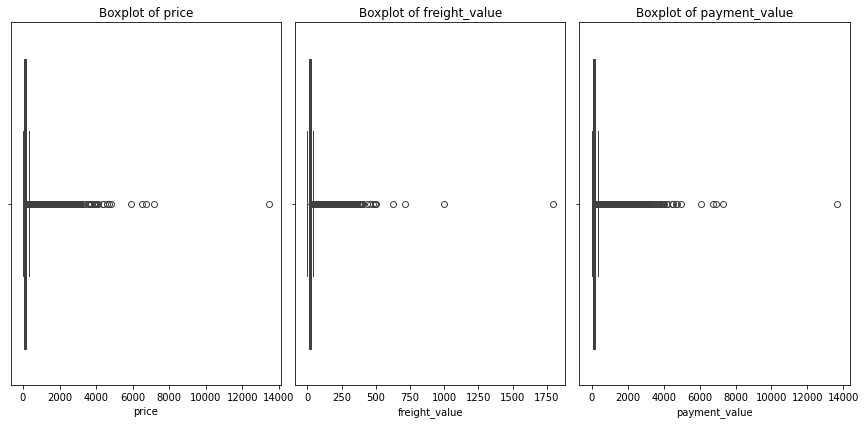

In [367]:
columns_to_check = ['price', 'freight_value', 'payment_value']

outlier_info = {}

for column in columns_to_check:
    Q1 = sellers_order[column].quantile(0.25)
    Q3 = sellers_order[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_info[column] = {
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': ((sellers_order[column] < lower_bound) | (sellers_order[column] > upper_bound)).sum()
    }

for col, info in outlier_info.items():
    print(f'{col}: Lower Bound = {info['Lower Bound']}, Upper Bound = {info['Upper Bound']}, Outliers Count = {info['Outliers Count']}')

plt.figure(figsize = (12, 6))
for i, column in enumerate(columns_to_check):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x = sellers_order[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

price: Lower Bound = -111.0, Upper Bound = 305.0, Outliers Count = 7350
freight_value: Lower Bound = -1.2250000000000032, Upper Bound = 38.495000000000005, Outliers Count = 9733
payment_value: Lower Bound = -114.39999999999998, Upper Bound = 348.48, Outliers Count = 7438


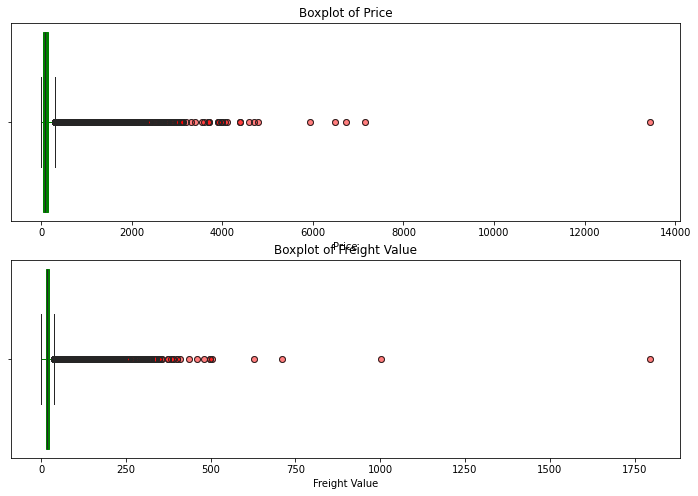

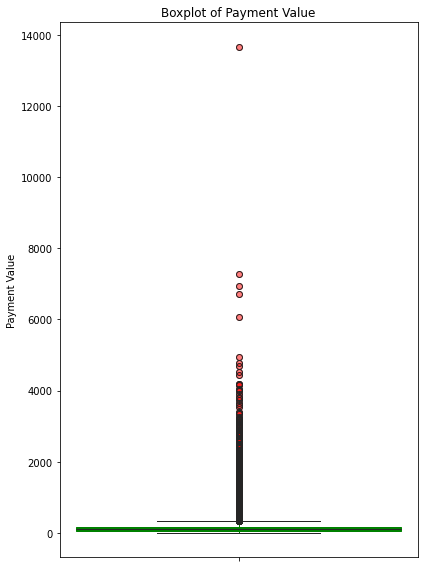

In [401]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Misalkan sellers_order adalah DataFrame Anda
# sellers_order = pd.read_csv('data.csv')  # Contoh pembacaan data

# Kolom yang akan dicek outlier
columns_to_check = ['price', 'freight_value', 'payment_value']

# Menghitung IQR dan mendeteksi outlier
outlier_info = {}

for column in columns_to_check:
    Q1 = sellers_order[column].quantile(0.25)
    Q3 = sellers_order[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_info[column] = {
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': ((sellers_order[column] < lower_bound) | (sellers_order[column] > upper_bound)).sum()
    }

# Menampilkan informasi outlier
for col, info in outlier_info.items():
    print(f"{col}: Lower Bound = {info['Lower Bound']}, Upper Bound = {info['Upper Bound']}, Outliers Count = {info['Outliers Count']}")

# Visualisasi dengan boxplot
plt.figure(figsize=(12, 8))

# Boxplot untuk price (horizontal)
plt.subplot(2, 1, 1)
sns.boxplot(x=sellers_order['price'], color='green', boxprops=dict(facecolor='green', color='green'), whiskerprops=dict(color='green'))

# Mengubah warna outlier
outliers_price = sellers_order['price'][(sellers_order['price'] < outlier_info['price']['Lower Bound']) |
                                         (sellers_order['price'] > outlier_info['price']['Upper Bound'])]
plt.scatter(outliers_price, [0] * len(outliers_price), color='red', alpha=0.5, label='Outliers')

plt.title('Boxplot of Price')
plt.xlabel('Price')

# Boxplot untuk freight_value (horizontal)
plt.subplot(2, 1, 2)
sns.boxplot(x=sellers_order['freight_value'], color='green', boxprops=dict(facecolor='green', color='green'), whiskerprops=dict(color='green'))

# Mengubah warna outlier
outliers_freight = sellers_order['freight_value'][(sellers_order['freight_value'] < outlier_info['freight_value']['Lower Bound']) |
                                                   (sellers_order['freight_value'] > outlier_info['freight_value']['Upper Bound'])]
plt.scatter(outliers_freight, [0] * len(outliers_freight), color='red', alpha=0.5, label='Outliers')

plt.title('Boxplot of Freight Value')
plt.xlabel('Freight Value')

# Boxplot untuk payment_value (vertical)
plt.figure(figsize=(6, 8))
plt.subplot(1, 1, 1)
sns.boxplot(y=sellers_order['payment_value'], color='green', boxprops=dict(facecolor='green', color='green'), whiskerprops=dict(color='green'))

# Mengubah warna outlier untuk payment_value
outliers_payment = sellers_order['payment_value'][(sellers_order['payment_value'] < outlier_info['payment_value']['Lower Bound']) |
                                                   (sellers_order['payment_value'] > outlier_info['payment_value']['Upper Bound'])]
plt.scatter([0] * len(outliers_payment), outliers_payment, color='red', alpha=0.5, label='Outliers')

plt.title('Boxplot of Payment Value')
plt.ylabel('Payment Value')

plt.tight_layout()
plt.show()

In [372]:
display(sellers_order.select_dtypes([int]).head())

display(sellers_order[['order_item_count', 'payment_installments', 'payment_sequential', 'review_score']].describe().round(2))

,order_item_count,payment_installments,payment_sequential,review_score
1,1,3,1,4
2,1,5,1,5
3,1,2,1,4
4,1,3,1,5
5,1,1,1,4


,order_item_count,payment_installments,payment_sequential,review_score
count,96884.00,96884.00,96884.00,96884.00
mean,1.12,2.90,1.02,4.13
std,0.50,2.71,0.32,1.30
min,1.00,0.00,1.00,1.00
25%,1.00,1.00,1.00,4.00
50%,1.00,2.00,1.00,5.00
75%,1.00,4.00,1.00,5.00
max,21.00,24.00,25.00,5.00


Focus : Penjualan Rendah

Solusi :
2 Fitur Baru
> Seller untuk sales rendah (tapi bisa juga untuk Seller lain selain yang salesnya rendah)

Membuat fitur premium untuk menunjukkan statistik performa penjualan seller terkait (spesifikasi akan dibahas lebih lanjut)

Untuk seller dengan growth rate rendah (syaratnya ...), diberikan kemudahan untuk mencoba fitur premium secara free selama 3 bulan, setelah 3 bulan jika seller tersebut mencapai growth sebesar 20%, si seller akan diberikan diskon untuk fitur premium untuk 3 bulan selanjutnya

> Seller yang akan bermitra

Untuk seller baru join, akan diberikan rekomendasi terkait barang apa yang penjualannya bagus di kota dia tinggal beserta rata - rata harga per barangnya

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Misalkan sellers_order adalah DataFrame Anda
# sellers_order = pd.read_csv('data.csv')  # Contoh pembacaan data

# Kolom yang akan dicek outlier
columns_to_check = ['price', 'freight_value', 'payment_value']

# Menghitung IQR dan mendeteksi outlier
outlier_info = {}

for column in columns_to_check:
    Q1 = sellers_order[column].quantile(0.25)
    Q3 = sellers_order[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_info[column] = {
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': ((sellers_order[column] < lower_bound) | (sellers_order[column] > upper_bound)).sum()
    }

# Menampilkan informasi outlier
for col, info in outlier_info.items():
    print(f"{col}: Lower Bound = {info['Lower Bound']}, Upper Bound = {info['Upper Bound']}, Outliers Count = {info['Outliers Count']}")

# Visualisasi dengan boxplot
plt.figure(figsize=(12, 6))

# Subplot untuk price (horizontal) di posisi (1, 1)
plt.subplot(2, 2, 1)
sns.boxplot(x=sellers_order['price'], color='green', boxprops=dict(facecolor='green', color='green'), whiskerprops=dict(color='green'))

# Mengubah warna outlier
outliers_price = sellers_order['price'][(sellers_order['price'] < outlier_info['price']['Lower Bound']) |
                                         (sellers_order['price'] > outlier_info['price']['Upper Bound'])]
plt.scatter(outliers_price, [0] * len(outliers_price), color='red', alpha=0.5)

plt.title('Boxplot of Price')
plt.xlabel('Price')

# Subplot untuk freight_value (horizontal) di posisi (1, 2)
plt.subplot(2, 2, 2)
sns.boxplot(x=sellers_order['freight_value'], color='green', boxprops=dict(facecolor='green', color='green'), whiskerprops=dict(color='green'))

# Mengubah warna outlier
outliers_freight = sellers_order['freight_value'][(sellers_order['freight_value'] < outlier_info['freight_value']['Lower Bound']) |
                                                   (sellers_order['freight_value'] > outlier_info['freight_value']['Upper Bound'])]
plt.scatter(outliers_freight, [0] * len(outliers_freight), color='red', alpha=0.5)

plt.title('Boxplot of Freight Value')
plt.xlabel('Freight Value')

# Subplot untuk payment_value (vertical) di posisi (2, 1)
plt.subplot(2, 1, 2)
sns.boxplot(y=sellers_order['payment_value'], color='green', boxprops=dict(facecolor='green', color='green'), whiskerprops=dict(color='green'))

# Mengubah warna outlier untuk payment_value
outliers_payment = sellers_order['payment_value'][(sellers_order['payment_value'] < outlier_info['payment_value']['Lower Bound']) |
                                                   (sellers_order['payment_value'] > outlier_info['payment_value']['Upper Bound'])]
plt.scatter([0] * len(outliers_payment), outliers_payment, color='red', alpha=0.5)

plt.title('Boxplot of Payment Value')
plt.ylabel('Payment Value')

plt.tight_layout()
plt.show()